# Test out VAEs

## Outline
Is equivariance to affine transfroms really useful?
In this work we investigate the usefulness of directly encoding an affine transfrom layer into a generative model. We show that training using data sugmentation requires much more model parameters?????? and show a way to trade off approximately using a transfrom, and computing the optimal transfrom, based on the observation that the optimal transfrom should be the one that reduces the reconstruction error of the VAE.

#### VAEs perfrom poorly on affine transforms
VAEs perfrom poorly for reconstructing data that has been transformed by a simple, but out of training set affine transfrom. ??? From this, can we assume that the generative model is not able to create these? Saying it gets low reconstruction error on a sample isn't statistical enough. Possibly: The fact that the reconstruction loss is higher here, as shown also by these examples, indicates that the model is unable to properly conpute p(z|x) using the encoder. EXAMPLE: graph of worse performance on rotated images.

#### Augmentation takes more latent vectors than it should to do this / intrinsic dimension
This is to be expected of course, normally this is the reason data augmentation is used. Unfortunately, for this a more complex model is needed (EXAMPLE REALLY NEEDED HERE). As shown by the reconstruction error performance, the model trained on rotated data needs a larger latent space than the model only using one orientation. INTRINSIC DIMENSION???

In the ideal case, the rotation could be parametrized by only one parameter, theta, yet here we see that it takes the model xxxx extra parameters to overcom this issue. It would be nicer to have a model that would automatically handle these simple affine transforms. We know how to represent a transfrom that explicitly does, this, so we can directly encode it into the model.

#### STN et al?? is only approximate. We can compute it (mostly) exactly
The Spatial Transformer network was designed to overcome these issues for the problem of classification. Here an affine transfrom is applied to the input image, where the parameters of this transform are computed based off of another neural network. This means that the spatial transfromer has no way to evaluate if the transfrom it applied was optimal. In the case of the VAE, we could say that the spatial transfromer approximates the optimal transform (EXAMPLES of stn performing well, as well as poorly.) We see that the transfromation learned by the STN differs by the optimal transfrom by xxx degrees, and it is associated with a ""Loss"" of xxxx more.

We see that the optimal transform learned by the random/explicit optimization is on average xxx far from the true rotation, and achieves a loss of XXX from the optimal loss. Can we prove that this converges under some conditions? Maybe based on the paper the Neuroscience person presented??? Or just assume with enough random restarts we will get sufficiently close to the true optium that it will be locally convex? Is this how NNs work? Either way probably not practically relevant.

In [1]:
import os
import sys
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image, ImageOps

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

from utils.display import read_img_to_np, torch_to_np
from utils.norms import MNIST_norm
import model.model as module_arch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
from model.model import AffineVAE

device = torch.device("cuda:0")

from data_loader.data_loaders import make_generators_MNIST, make_generators_MNIST_CTRNFS

In [2]:
def get_model_loaders_config(PATH, old_gpu='cuda:0', new_gpu='cuda:1'):
    """PATH: path to dir where training results of a run are saved"""
    PATH = Path(PATH)
    config_loc = PATH / 'config.json'
    weight_path = PATH / 'model_best.pth'
    config = json.load(open(config_loc))
    
    
    def get_instance(module, name, config, *args):
        return getattr(module, config[name]['type'])(*args, **config[name]['args'])

    data_loader = get_instance(module_data, 'data_loader', config)['train']
    valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
    model = get_instance(module_arch, 'arch', config)
    model = model.to(torch.device(new_gpu))
    checkpoint = torch.load(weight_path, map_location={'cuda:0': 'cuda:1'})
    state_dict = checkpoint['state_dict']
    
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)

    model.load_state_dict(state_dict)
    model = model.to(device).eval()
    
    loss_fn = get_instance(module_loss, 'loss', config)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    return model, data_loader, valid_data_loader, loss_fn, metric_fns, config


def display_batch(x, recon_x):
    """Display tensor images"""
    fig, ax = plt.subplots(x.size()[0], 2, sharex='col', sharey='row',figsize=(10,10))
    for i in range(x.size()[0]):
        ax[i, 0].imshow(torch_to_np(x[i]), cmap='Greys',  interpolation='nearest')
        ax[i, 1].imshow(torch_to_np(recon_x[i]), cmap='Greys',  interpolation='nearest')
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    plt.show()

        
def visualize_dataloader(data_loader, device, num_samples=6, bw=True):
    """Randomly sample from dataloader and display"""
    with torch.cuda.device(device.index):
        fig, ax = plt.subplots(int(num_samples/2), 2, sharex='col', sharey='row',figsize=(10,10))
        for i in range(0, int(num_samples/2)):
            # sample randomly from the nth batch for the nth row of imgs
            data, label = next(iter(data_loader))
            tensor_img = data[random.randint(0, data.size()[0]),:, :, :]
            ax[i, 0].imshow(torch_to_np(tensor_img), cmap='Greys',  interpolation='nearest')
            tensor_img = data[random.randint(0, data.size()[0]), :, :, :]
            ax[i, 1].imshow(torch_to_np(tensor_img), cmap='Greys',  interpolation='nearest')
            print(f'tensor_img size: {tensor_img.size()}')
            print(f'Max: {torch.max(tensor_img)}, Min: {torch.min(tensor_img)}')
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')
    

def display_results_auto(vae_model, config, device, rotate=0, pad = 6,
                         norm=None, num_samples=3, data='bw', size = 28, label_col_name='label', save_loc=None):
    """ QUESTIONABLE, REDO IT"""
    with torch.cuda.device(device.index): # ??? Why the fuck???        
        files_dict_loc = config['data_loader']['args']['files_dict_loc']
        with open(files_dict_loc, 'rb') as f:
            files_df = pickle.load(f)['train']
            
        if label_col_name:
            all_labels = files_df[label_col_name].unique()
        else:
            all_labels = list(range(num_samples))
        row_names = []
        col_names = ['Original', "Reconstructed"]

        fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(10,10))

        for i, label in enumerate(all_labels[0:num_samples]):
            if label_col_name:
                sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
                label = sample_df[label_col_name].iloc[0]
                row_names.append(label)
            else:
                sample_df = files_df.sample(n=1)
            img_path = sample_df['path'].iloc[0]

            if data == 'bw': # Assume MNIST
                img = read_img_to_np(img_path, bw=True)
                transform = transforms.Compose([
                                                transforms.RandomRotation((rotate, rotate), expand=True),
                                                transforms.Resize(size),
                                                transforms.Pad((pad, pad)),
                                                transforms.ToTensor(),
                                                transforms.Normalize(*MNIST_norm)])
            else:
                img = read_img_to_np(img_path, bw=False, size=size)
                transform = transforms.Compose([
                                                transforms.RandomRotation((rotate, rotate), expand=True),
                                                transforms.Resize(size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(*norm)])

            tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)
            output = vae_model(tensor_img,  deterministic=False)
            recon_x = output[0]
            
            ax[i, 0].imshow(torch_to_np(tensor_img), cmap='Greys',  interpolation='nearest')
            ax[i, 1].imshow(torch_to_np(recon_x), cmap='Greys',  interpolation='nearest')
            ax[i, 0].axis('off')
            ax[i, 1].axis('off')

        for curr_ax, col in zip(ax[0], col_names):
            curr_ax.set_title(col)
        if label_col_name:
            for curr_ax, row in zip(ax[:,0], row_names):
                curr_ax.set_ylabel(row, rotation=0, size='large')
        if save_loc:
            plt.savefig(save_loc, bbox_inches='tight')

In [3]:
def pad_to_size(img, new_size):
    delta_width = new_size - img.size()[1]
    delta_height = new_size - img.size()[2]
    pad_width = delta_width //2
    pad_height = delta_height //2
    img = F.pad(img, (pad_height, pad_height, pad_width, pad_width), 'constant', 0)
    return img

def rotate_mnist_batch(x, return_size=40, fixed_rotation=None):
    """Rotate batch without squishing the img. Pad all imgs to same size"""
    batch_size = x.shape[0]
    rot_x = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if fixed_rotation:
            img = TF.rotate(img, fixed_rotation)

        img = transforms.ToTensor()(img)
        if return_size:
            img = pad_to_size(img, return_size)
        # MNIST norm, wrong because imgs are padded
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        rot_x[i, :, :, :] = img
    return rot_x
    

def get_vae_MNIST_perf(model, data_loader, loss_fn, metric_fns, device, fixed_rotation, return_size):
    """Evaluate performance on MNIST Dataset using a given rotation
    
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()

        total_loss = 0.0
        total_metrics = torch.zeros(len(metric_fns))

        with torch.no_grad():
            for i, (data, target) in enumerate(tqdm(data_loader)):
                batch_size = data.shape[0]
                new_data = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                new_data, target = new_data.to(device), target.to(device)
                output = model(new_data, deterministic=True)

                # computing loss, metrics on test set
                loss = loss_fn(output, new_data)
                total_loss += loss.item() * batch_size
                for i, metric in enumerate(metric_fns):
                    total_metrics[i] += metric(output, new_data) * batch_size

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / n_samples}
        log.update({met.__name__ : total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
        return log

## Visualize Dataloader

tensor_img size: torch.Size([1, 28, 28])
Max: 1.0, Min: 0.0
tensor_img size: torch.Size([1, 28, 28])
Max: 1.0, Min: 0.0
tensor_img size: torch.Size([1, 28, 28])
Max: 1.0, Min: 0.0


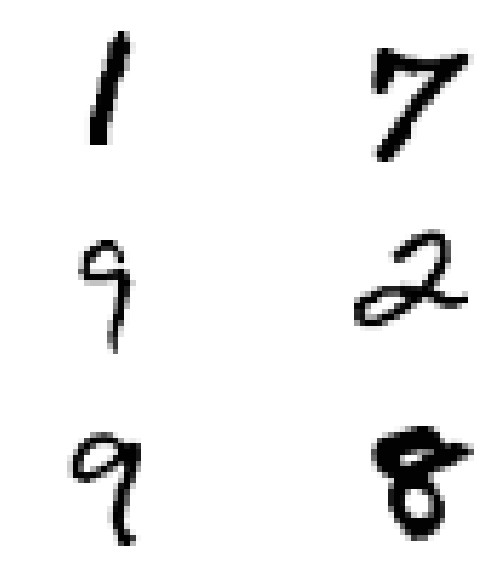

In [4]:
PATH = '/media/rene/data/equivariance/mnist_tmp/0125_234629'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(PATH, old_gpu='cuda:1', new_gpu='cuda:1')
visualize_dataloader(data_loader, device, num_samples=6, bw=True)

## Check normalization
* Without normalization padding =0, must be equivalent

In [21]:
config_loc = '/media/rene/data/equivariance/mnist_tmp/0125_234629'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
x, y = next(iter(valid_data_loader))
print(f'Loader from config: Max: {torch.max(x)}, Min: {torch.min(x)}')

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
with open(files_dict_loc, 'rb') as f:
    files_df = pickle.load(f)['val']
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
x, y = next(iter(data_loaders['val']))
print(f'MNIST Loader no Norm: Max: {torch.max(x)}, Min: {torch.min(x)}')

data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=True)
x, y = next(iter(data_loaders['val']))
print(f'MNIST Loader w/ Norm: Max: {torch.max(x)}, Min: {torch.min(x)}')

print(f'Expected MNIST norm: Max: {(1-0.1307)/0.3081}, Min: {-0.1307/0.3081}')

Loader from config: Max: 2.821486711502075, Min: -0.4242129623889923
MNIST Loader no Norm: Max: 1.0, Min: 0.0
MNIST Loader w/ Norm: Max: 2.821486711502075, Min: -0.4242129623889923
Expected MNIST norm: Max: 2.82148653034729, Min: -0.424212917883804


## ???? REDO? MNIST - Check Autoencoder

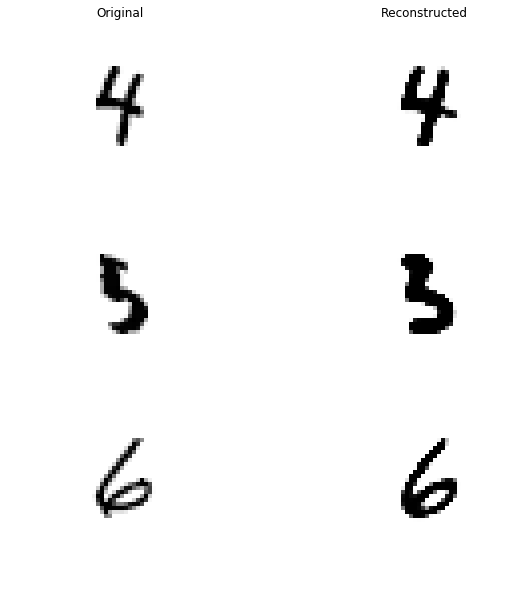

In [22]:
config_loc = '/media/rene/data/equivariance/mnist_tmp/0125_234629'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
display_results_auto(model, config, device, rotate=0, num_samples=3, label_col_name='class', save_loc=None)

## Performance on rotated images
* Test the performance on rotated samples 
* Model was not trained with rotation

In [1]:
# config_loc = '/media/rene/data/equivariance/mnist_tmp/0125_234629'
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'

model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')


files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
with open(files_dict_loc, 'rb') as f:
    files_df = pickle.load(f)['val']
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
for rotation in range(0, 180, 15):
    log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                             fixed_rotation=rotation, return_size=40)
    log['rotation'] = rotation
    results = results.append(log, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(results['rotation'], results['loss'])

ax.set(xlabel='Rotation (degrees)', ylabel='VAE Loss')
#        title='VAE Loss vs. Rotation')

plt.savefig('/media/rene/code/equivariance/imgs/vae_loss_rotation.png', bbox_inches='tight')
plt.show()

NameError: name 'get_model_loaders_config' is not defined

## Look at examples of rotated images

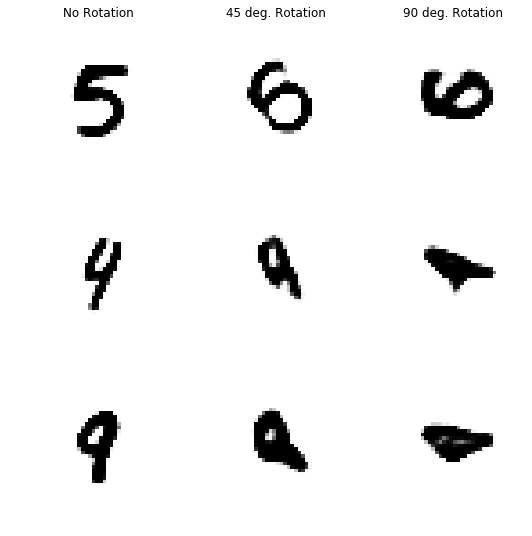

In [40]:
def display_vae_rot(model, files_dict_loc, num_samples=3, save_loc=None):
    
    data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
    x, y = next(iter(data_loaders['val']))
    rot_0 = rotate_mnist_batch(x, return_size=40, fixed_rotation=0)
    rot_45 = rotate_mnist_batch(x, return_size=40, fixed_rotation=45)
    rot_90 = rotate_mnist_batch(x, return_size=40, fixed_rotation=90)

    fig, ax = plt.subplots(num_samples, 3, sharex='col', sharey='row'c)
    col_names = ['No Rotation', '45 deg. Rotation', '90 deg. Rotation']
    
    for i in range(num_samples):
        idx = random.randint(0, x.size()[0])
        img = x[idx, :, :, :].unsqueeze(0)
        img = img.to(device)
        rot_0_img = rot_0[idx, :, :, :].unsqueeze(0)
        rot_0_img = rot_0_img.to(device)
        rot_45_img = rot_45[idx, :, :, :].unsqueeze(0)
        rot_45_img = rot_45_img.to(device)
        rot_90_img = rot_90[idx, :, :, :].unsqueeze(0)
        rot_90_img = rot_90_img.to(device)

        rot_0_output = model(rot_0_img,  deterministic=True)
        rot_45_output = model(rot_45_img,  deterministic=True)
        rot_90_output = model(rot_90_img,  deterministic=True)

        ax[i, 0].imshow(torch_to_np(rot_0_output[0]), cmap='Greys',  interpolation='nearest')
        ax[i, 1].imshow(torch_to_np(rot_45_output[0]), cmap='Greys',  interpolation='nearest')
        ax[i, 2].imshow(torch_to_np(rot_90_output[0]), cmap='Greys',  interpolation='nearest')
        
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
    
#     fig.suptitle('VAE Reconstruction Performance vs. Rotation', size='xx-large')
    for curr_ax, col in zip(ax[0], col_names):
        curr_ax.set_title(col)

    if save_loc:
        plt.savefig(save_loc, bbox_inches='tight')
        
    
    plt.show()
        
display_vae_rot(model, files_dict_loc, num_samples=3, 
                save_loc='/media/rene/code/equivariance/imgs/vae_loss_rotation_ex.png')

## How big should the latent size be for rotated and unrotated?
* Look at the average performace over 5 runs for each latent size, for both the rotated and unrotated models
* Both VAEs evaluated on same unrotated set, idea is that the limited model capicity will hurt reconstruction error for all rotations equally, and by fixing it at one rotation we are able to better compare the two models.

## ??? Should we be evaluating deterministically or not?

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


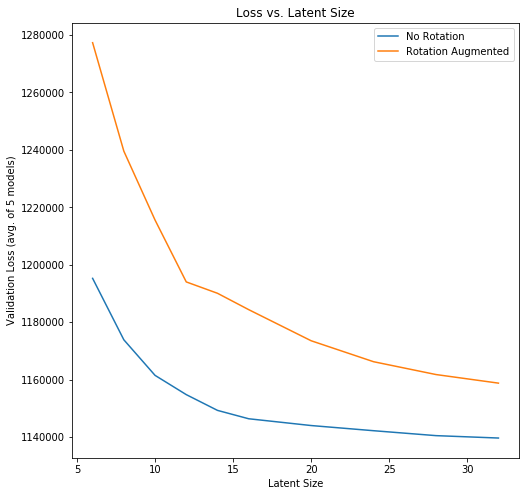

In [5]:
files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
with open(files_dict_loc, 'rb') as f:
    files_df = pickle.load(f)['val']
# this is the standard dataloader returning unaugmented unnormalized mnist 28x28
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=2048, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

latent_list = [32, 28, 24, 20, 16, 14, 12, 10, 8, 6]
results = pd.DataFrame()

log = {}
for i, latent_size in enumerate(latent_list):
    loc = '/media/rene/data/equivariance/mnist/vae_mnist_L' + str(latent_size)
    tmp_loss_list = []
    for file_path in list(Path(loc).glob('**/*config.json')):
        # get the model (ignore this dataloader, always use same one)
        config_loc = file_path.parent
        model, __data_loader, __valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
        tmp_log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                                     fixed_rotation=None, return_size=40)
        tmp_loss_list.append(tmp_log['loss'])
    
    log['latent_size'] = latent_size 
    log['loss'] = np.mean(tmp_loss_list)
    results = results.append(log, ignore_index=True)
    
# Rotation augmneted
results_rot = pd.DataFrame()
log = {}
for i, latent_size in enumerate(latent_list):
    loc = '/media/rene/data/equivariance/mnist/vae_mnist_L' + str(latent_size) +'_rotate'
    tmp_loss_list = []
    for file_path in list(Path(loc).glob('**/*config.json')):
        # get the model (ignore this dataloader, always use same one)
        config_loc = file_path.parent
        model, __data_loader, __valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
        tmp_log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                                     fixed_rotation=None, return_size=40)
        tmp_loss_list.append(tmp_log['loss'])
    
    log['latent_size'] = latent_size 
    log['loss'] = np.mean(tmp_loss_list)
    results_rot = results_rot.append(log, ignore_index=True)
    
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(results['latent_size'], results['loss'], label="No Rotation")
ax.plot(results_rot['latent_size'], results_rot['loss'], label="Rotation Augmented")

ax.set(xlabel='Latent Size', ylabel='Validation Loss (avg. of 5 models)',
       title='Loss vs. Latent Size')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/latent_size_perf.png')
plt.show()

### No data augmentation

100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


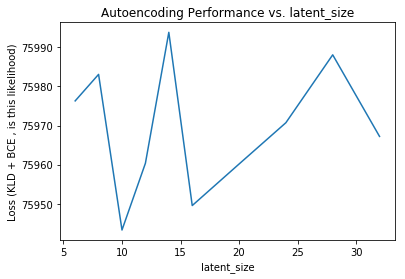

In [18]:
# ???！！！ Delete 

PATH = '/media/rene/data/equivariance/mnist/vae_mnist_L32/0125_234629'

# this is the standard dataloader returning unaugmented unnormalized mnist
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, fixed_rotation=None, normalize=False)
config_loc_list = [
                   '/media/rene/data/equivariance/mnist/vae_mnist_L32/0125_234629',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L28/0125_230835',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L24/0125_224234',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L20/0125_221652',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L16/0125_214506',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L14/0125_211747',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L12/0125_204921',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L10/0125_202049',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L8/0125_194004',
                   '/media/rene/data/equivariance/mnist/vae_mnist_L6/0125_191150'
                   ]
latent_size = [32, 28, 24, 20, 16, 14, 12, 10, 8, 6]
results = pd.DataFrame()

for i, config_loc in enumerate(config_loc_list):
    model, __data_loader, __valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(PATH, old_gpu='cuda:1', new_gpu='cuda:1')
    log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                             fixed_rotation=None, return_size=40)
    log['latent_size'] = latent_size[i]
    results = results.append(log, ignore_index=True)

    
fig, ax = plt.subplots()
ax.plot(results['latent_size'], results['loss'])

ax.set(xlabel='latent_size', ylabel='Loss (KLD + BCE , is this likelihood)',
       title='Autoencoding Performance vs. latent_size (averaged over 5 training runs)')
plt.show()

# STN VAE
* Affine VAE is just a normal VAE added inside the model, no new trained parameters
* For STN VAE the STN must be trained

## Check a few examples

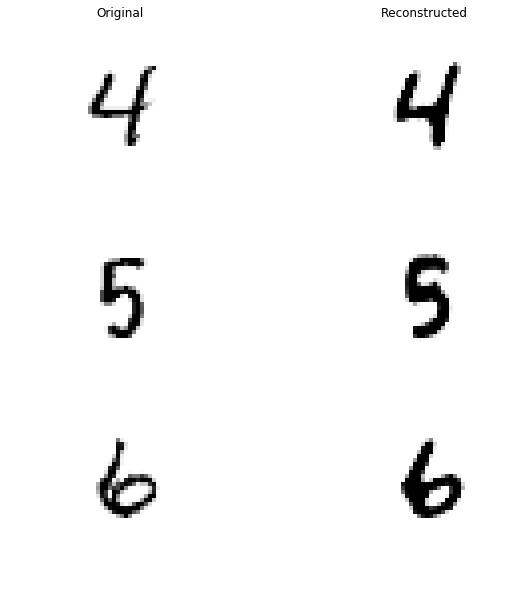

In [9]:
config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16_rotate/0204_164911'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
display_results_auto(model, config, device, rotate=0, num_samples=3, label_col_name='class', save_loc=None)

## Test affine and affine inverse functions

In [96]:
# affine_params =  torch.tensor([1.5, 0, 0, 0, 1.5, 0], dtype=torch.float).view(2, 3).to(device)
theta = torch.tensor([math.pi/2]).float()
affine_params = torch.cat([torch.cos(theta), torch.sin(theta), torch.tensor([0]).float(),
                           -1*torch.sin(theta), torch.cos(theta), torch.tensor([0]).float()]).view(2, 3)
affine_params = affine_params.expand(x.size()[0], affine_params.size()[0], affine_params.size()[1]).clone()

data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28)

x, y = next(iter(valid_data_loader))
x = x.to(device)

x_affine = affine_model.affine(x, affine_params)
x_affine_recon, mu_logvar = affine_model.VAE(x_affine)
x_affine_recon_inv = affine_model.affine_inv(x_recon, affine_params)
x_affine_inv = affine_model.affine_inv(x_affine, affine_params)

# recon_x, mu_logvar, affine_params = affine_model(x, affine_params=None, deterministic=False)
# display_results_auto(affine_model, config, device, rotate=0, num_samples=3, size = 40, label_col_name='class', save_loc=None)

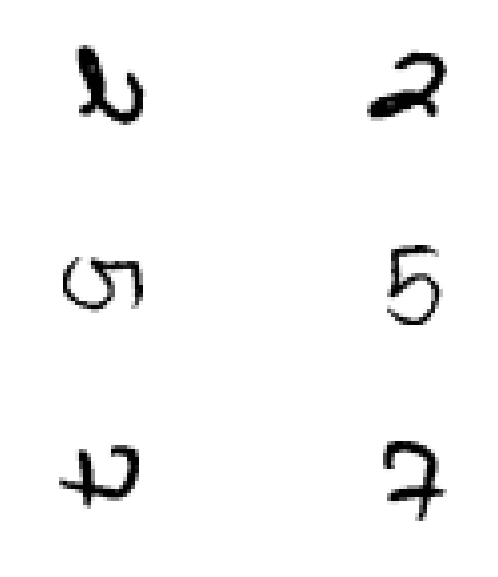

In [99]:
display_batch(x_affine[:3, :, :], x_affine_inv[:3, :, :])
# display_batch(x_affine_recon[5:7, :, :], x_affine_recon_inv[5:7, :, :])

# Rotation augmented STN vs. non-Rotation augmented.
* Here we compare the exact same model trained using augmented and non-augmented data.
* This isn't a good comparision, because here we are confusing the benefit of the STN module, with the rotation augmentation (rotation augmentation alone is useful)

#### STN without rotation augmentation is same as normal VAE

In [ ]:
# config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16/0204_164900'
# model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')

# files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
# with open(files_dict_loc, 'rb') as f:
#     files_df = pickle.load(f)['val']
# data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
#                                             return_size=28, rotation_range=None, normalize=False)

# results = pd.DataFrame()
# for rotation in range(0, 180, 15):
#     log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
#                              fixed_rotation=rotation, return_size=40)
#     log['rotation'] = rotation
#     results = results.append(log, ignore_index=True)
    
# fig, ax = plt.subplots()
# ax.plot(results['rotation'], results['loss'])

# ax.set(xlabel='Rotation (degrees)', ylabel='Loss (KLD + BCE , is this likelihood)',
#        title='Autoencoding Performance vs. Rotation')
# plt.show()

# Train the STN module only
* Same number of epochs, etc. but this time there is rotation augmentation

In [ ]:
from trainer import Trainer
from utils import Logger
train_logger = Logger()
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16/0204_164900'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')

for p in model.parameters():
    model.VAE.requires_grad = False

config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16/0204_164900'
model, data_loader, valid_data_loader, loss, metrics, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')
config['trainer']['verbosity'] = 0
config['trainer']['save_dir'] = '/media/rene/data/equivariance/mnist/stn_training'
config['trainer']['log_dir'] = config['trainer']['save_dir']
config['trainer']['rotation_range'] = [0, 360]
config['trainer']['epochs'] = 300

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

trainer = Trainer(model, loss, metrics, optimizer,
                  resume=False,
                  config=config,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler,
                  train_logger=train_logger)
# trainer.train()

Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch3.pth ...
Saving current best: model_best.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch4.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch5.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028/checkpoint-epoch6.pth ...
Saving current best: model_best.pth ...
Saving checkpoint: /media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_22502

100%|██████████| 79/79 [00:03<00:00, 22.08it/s]


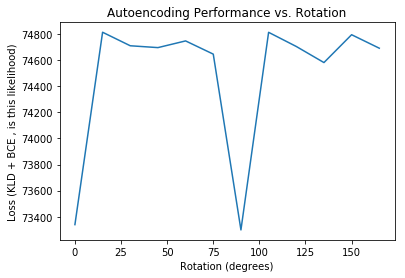

In [10]:
# config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16_rotate/0204_164911'
# model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')

# files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
# with open(files_dict_loc, 'rb') as f:
#     files_df = pickle.load(f)['val']
# data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
#                                             return_size=28, rotation_range=None, normalize=False)

# results = pd.DataFrame()
# for rotation in range(0, 180, 15):
#     log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
#                              fixed_rotation=rotation, return_size=40)
#     log['rotation'] = rotation
#     results = results.append(log, ignore_index=True)
    
# fig, ax = plt.subplots()
# ax.plot(results['rotation'], results['loss'])

# ax.set(xlabel='Rotation (degrees)', ylabel='Loss (KLD + BCE , is this likelihood)',
#        title='Autoencoding Performance vs. Rotation')
# plt.show()

## With and without using STN on identical VAE
* Difference is the one t

100%|██████████| 79/79 [00:04<00:00, 16.38it/s]


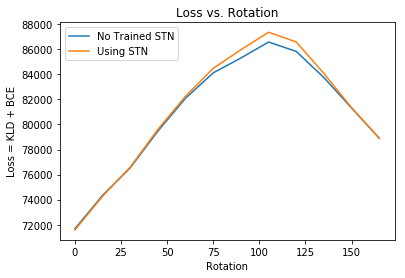

In [4]:
config_loc = '/media/rene/data/equivariance/mnist/stn_vae_mnist_L16/0204_164900'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
# with open(files_dict_loc, 'rb') as f:
#     files_df = pickle.load(f)['val']
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
for rotation in range(0, 180, 15):
    log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                             fixed_rotation=rotation, return_size=40)
    log['rotation'] = rotation
    results = results.append(log, ignore_index=True)
    
# trained stn
config_loc = '/media/rene/data/equivariance/mnist/stn_training/stn_vae_mnist_L16/0207_225028'
model, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:1')

results_stn = pd.DataFrame()
for rotation in range(0, 180, 15):
    log = get_vae_MNIST_perf(model, data_loaders['val'], loss_fn, metric_fns, device, 
                             fixed_rotation=rotation, return_size=40)
    log['rotation'] = rotation
    results_stn = results_stn.append(log, ignore_index=True)

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss'], label="No Trained STN")
ax.plot(results_stn['rotation'], results_stn['loss'], label="Using STN")

ax.set(xlabel='Rotation', ylabel='Loss = KLD + BCE',
       title='Loss vs. Rotation')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/rotation_stn_perf.png')
plt.show()

### STN VAE Result
It seems that the STN doesn't help much, and the majority of the help comes from using the augmentation.

## Average loss for affine Rotation and an image rotation:

In [4]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=16, use_STN=False)
affine_model = affine_model.to(device)

/home/rene/miniconda3/envs/HVAE/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


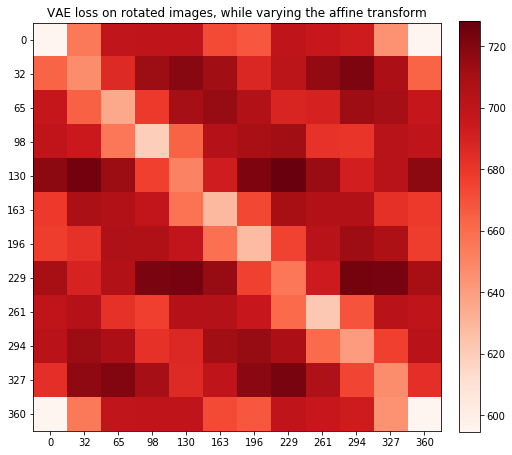

In [10]:
files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
batch_size = 20
num_evals = 12
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=batch_size, num_workers=4,
                                            return_size=28, rotation_range=None, normalize=False)

x, y = next(iter(data_loaders['val']))
thetas = np.linspace(0, 2*math.pi, num_evals)
degrees = [180*x/math.pi for x in thetas]
results = np.zeros((num_evals, num_evals))
for i, affine_rotation in enumerate(thetas):
    for j, img_rotation in enumerate(degrees):
        rot_x = rotate_mnist_batch(x, return_size=40, fixed_rotation=img_rotation)
        curr_loss = 0
        for idx in range(batch_size):
            img = rot_x[idx, :, :, :].unsqueeze(0)
            img = img.to(device)

            output = affine_model(img, deterministic=True, theta=affine_rotation)
            loss = loss_fn(output, img)
            curr_loss += loss.item()
        results[i, j] = curr_loss/batch_size
    
degrees = [int(x) for x in degrees]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(results, interpolation='none', cmap=plt.cm.Reds)
ax.set_xticks(np.arange(len(degrees)))
ax.set_yticks(np.arange(len(degrees)))
ax.set_xticklabels(degrees)
ax.set_yticklabels(degrees)
ax.set_title("VAE loss on rotated images, while varying the affine transform")
fig.colorbar(im, fraction=0.046, pad=0.04)
fig.savefig('/media/rene/code/equivariance/imgs/affine_img_rot_perf_heatmap.png', bbox_inches='tight')
fig.show()

A minimum loss along the diagonal, where the image roatation is equal to the transformation, bringing the image back to the cannocal orientation. In the ideal case the loss should be equal and minimum along the diagonal. Since there is some change diring the affine transform do to interpolation, this is not exact.

In [4]:
def display_affine_vae(affine_model, loss, files_dict_loc, img_rotation, affine_rotation, 
                       num_samples=3, save_loc=None):
    
    data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
    x, y = next(iter(data_loaders['val']))
    rot_x = rotate_mnist_batch(x, return_size=40, fixed_rotation=img_rotation)
    x = rotate_mnist_batch(x, return_size=40, fixed_rotation=0)

    fig, ax = plt.subplots(num_samples, 6, sharex='col', sharey='row',figsize=(15,15))
    
    for i in range(num_samples):
        idx = random.randint(0, x.size()[0])
        img = x[idx, :, :, :].unsqueeze(0)
        img = img.to(device)
        rot_img = rot_x[idx, :, :, :].unsqueeze(0)
        rot_img = rot_img.to(device)
         
        output = affine_model.VAE(img,  deterministic=True)
        loss = loss_fn(output, img)
            
        rot_output = affine_model.VAE(rot_img,  deterministic=True)
        rot_loss = loss_fn(output, rot_img)
        
        affine_output = affine_model(rot_img, deterministic=True, theta=affine_rotation, return_affine=True)
        affine_loss = loss_fn(affine_output[:2], rot_img)
        
        affine_params = affine_output[2]
        affine_rot_img = affine_output[3]
#         affine_rot_img = affine_model.affine(rot_img, affine_params)

        ax[i, 0].imshow(torch_to_np(img), cmap='Greys',  interpolation='nearest')
        ax[i, 1].imshow(torch_to_np(output[0]), cmap='Greys',  interpolation='nearest')
        ax[i, 2].imshow(torch_to_np(rot_img), cmap='Greys',  interpolation='nearest')
        ax[i, 3].imshow(torch_to_np(rot_output[0]), cmap='Greys',  interpolation='nearest')
        ax[i, 4].imshow(torch_to_np(affine_rot_img), cmap='Greys',  interpolation='nearest')
        ax[i, 5].imshow(torch_to_np(affine_output[0]), cmap='Greys',  interpolation='nearest')
        
        ax[i, 0].title.set_text('img')
        ax[i, 1].title.set_text(f'Recon {loss.item():9.1f}')
        ax[i, 2].title.set_text('Rot img')
        ax[i, 3].title.set_text(f'Recon Rot{rot_loss.item():9.1f}')      
        ax[i, 4].title.set_text('Affine Transfrom')
        ax[i, 5].title.set_text(f'Recon affine {affine_loss.item():9.1f}')
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
        ax[i, 3].axis('off')
        ax[i, 4].axis('off')
        ax[i, 5].axis('off')

        if save_loc:
            plt.savefig(save_loc, bbox_inches='tight')

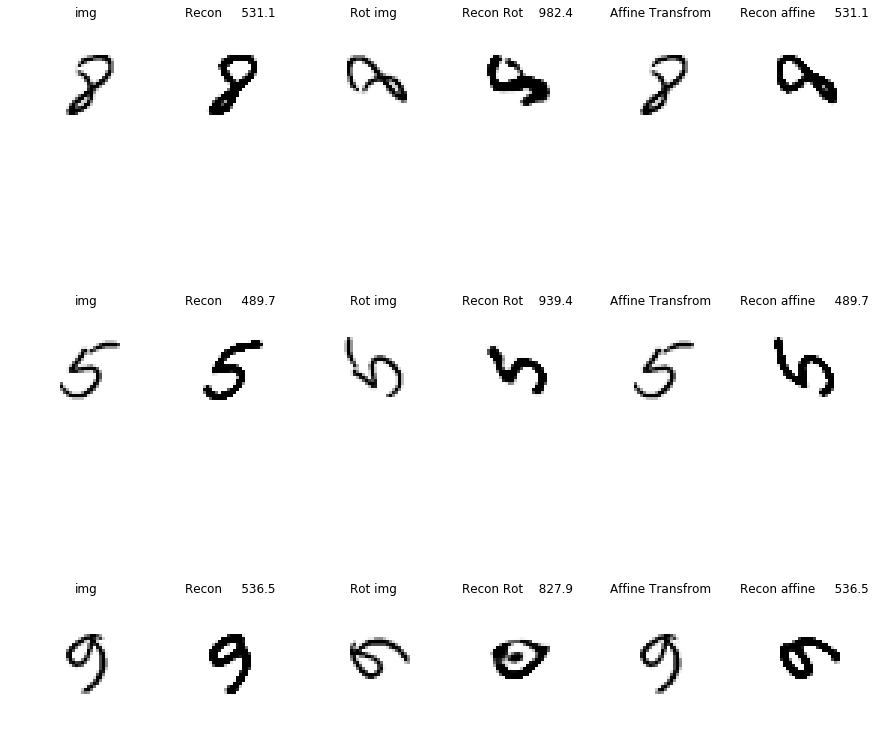

In [142]:
files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

display_affine_vae(affine_model, loss_fn, files_dict_loc, img_rotation=90, affine_rotation=(math.pi/2), 
                   num_samples=3, save_loc=None)

#### Looks resonable, the correctly rotated img has much lower error
Image generator rotates by degrees counterclockwise
Affine transform rotates by radians counterclockwise

## Optimizing rotation to reduce loss
* Non-rotation augmented VAE
* Even random search works here

In [6]:
def get_AFFINE_MNIST_perf(model, data_loader, loss_fn, metric_fns, device, fixed_rotation, return_size=40, optimize=False, iterations=0, num_trials=200):
    """Evaluate performance on MNIST Dataset using a given rotation
    
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()

        total_loss = 0.0
        total_metrics = torch.zeros(len(metric_fns))

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                rot_x = rotate_mnist_batch(data, return_size=40, fixed_rotation=fixed_rotation)
                rot_x, target = rot_x.to(device), target.to(device)
                if optimize:
                    best_affine_params, loss = affine_model.optimize_affine_params(rot_x, only_rotation=True, 
                                                                               num_times=num_trials, iterations=iterations)
                else:
                    output = model(rot_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, rot_x).item()

                total_loss += loss * batch_size
#                 for i, metric in enumerate(metric_fns):
#                     total_metrics[i] += metric(output, rot_x) * batch_size
                if i>1000:
                    break

        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / n_samples}
#         log.update({met.__name__ : total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
        return log

In [ ]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
results_opt = pd.DataFrame()
for rotation in range(0, 180, 15):
    log = get_AFFINE_MNIST_perf(affine_model, data_loaders['val'], loss_fn, metric_fns, device, fixed_rotation=rotation, 
                                optimize=False, return_size=40, iterations=0, num_trials=0)
    log['rotation'] = rotation
    results = results.append(log, ignore_index=True)
    
    log_opt = get_AFFINE_MNIST_perf(affine_model, data_loaders['val'], loss_fn, metric_fns, device, fixed_rotation=rotation, 
                                optimize=True, return_size=40, iterations=0, num_trials=50)
    log_opt['rotation'] = rotation
    results_opt = results_opt.append(log_opt, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_rot_nonopt_perf_50.csv')
results_opt.to_csv('/media/rene/code/equivariance/results/affine_rot_opt_perf_50.csv')

# results.to_csv('/media/rene/code/equivariance/results/affine_rot_nonopt_perf_500.csv')
# results_opt.to_csv('/media/rene/code/equivariance/results/affine_rot_opt_perf_500.csv')

fig, ax = plt.subplots()
ax.plot(results['rotation'], results['loss'], label="VAE")
ax.plot(results_opt['rotation'], results_opt['loss'], label="AVAE")

ax.set(xlabel='Rotation', ylabel='Loss = KLD + BCE',
       title='Effect of optimizing rotation on VAE loss')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/rotation_opt_perf_50.png', bbox='tight')
plt.show()

## Visualize the VAE optimization performace more clearly

In [11]:
def display_vae_avae_rot(avae_model, files_dict_loc, num_samples=6, save_loc=None):
    
    data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
    x, y = next(iter(data_loaders['val']))
    rot_90 = rotate_mnist_batch(x, return_size=40, fixed_rotation=90)

    fig, ax = plt.subplots(2, num_samples, sharex=True, sharey=True, figsize=(20,8))
    row_names = ['VAE', 'AVAE']
    
    for i in range(num_samples):
        idx = random.randint(0, x.size()[0])
        img = x[idx, :, :, :].unsqueeze(0)
        img = img.to(device)
        rot_90_img = rot_90[idx, :, :, :].unsqueeze(0)
        rot_90_img = rot_90_img.to(device)

        rot_90_vae_output = avae_model.VAE(rot_90_img, deterministic=True)
        
        best_affine_params, loss = affine_model.optimize_affine_params(rot_90_img, only_rotation=True, 
                                                                        num_times=50, iterations=0)
        
        rot_90_avae_output = avae_model(rot_90_img,  deterministic=True, affine_params=best_affine_params)
        
#         ax[0, i].imshow(torch_to_np(rot_90_img[:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        ax[0, i].imshow(torch_to_np(rot_90_vae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        ax[1, i].imshow(torch_to_np(rot_90_avae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        
        ax[0, 0].set_ylabel(row_names[0])
        ax[1, 0].set_ylabel(row_names[1])
#         ax[2, 0].set_ylabel(row_names[2])
#         ax[0, i].axis('off')
#         ax[1, i].axis('off')
#         ax[2, i].axis('off')
#     plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    
    if save_loc:
        plt.savefig(save_loc, bbox_inches='tight')
    
    plt.show()

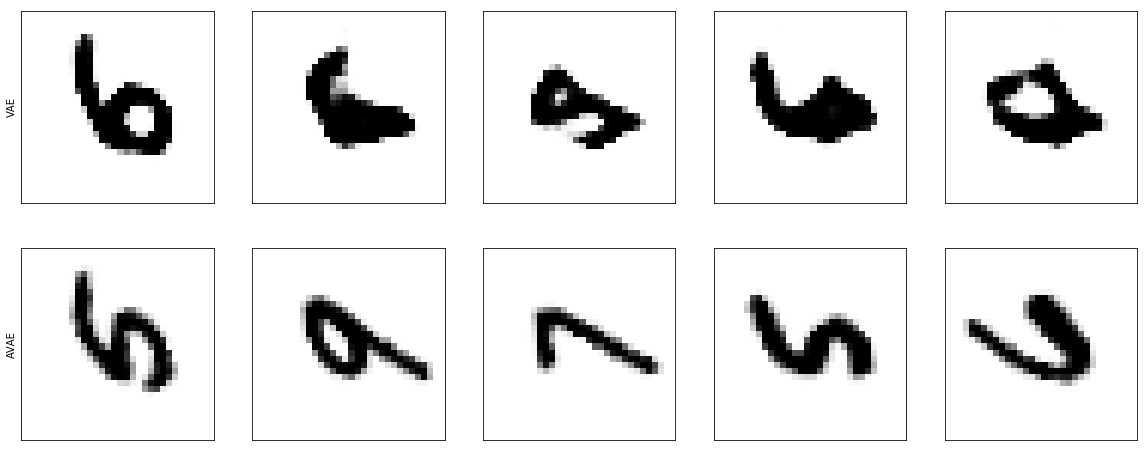

In [14]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'

display_vae_avae_rot(affine_model, files_dict_loc, num_samples=5, 
                     save_loc='/media/rene/code/equivariance/imgs/vae_avae_rotation_ex.png')

# Get some shears going

In [9]:
def pad_to_size(img, new_size):
    delta_width = new_size - img.size()[1]
    delta_height = new_size - img.size()[2]
    pad_width = delta_width //2
    pad_height = delta_height //2
    img = F.pad(img, (pad_height, pad_height, pad_width, pad_width), 'constant', 0)
    return img

def shear_mnist_batch(x, return_size=40, shear_angle=0):
    """Rotate batch without squishing the img. Pad all imgs to same size"""
    batch_size = x.shape[0]
    rot_x = torch.zeros((batch_size, 1, return_size, return_size))
    for i in range(batch_size):
        img = TF.to_pil_image(x[i, :, :])
        if shear_angle:            
            img = TF.affine(img, angle=shear_angle, translate=(0, 0), scale=1, 
                            shear=shear_angle, fillcolor=None)

        img = transforms.ToTensor()(img)
        if return_size:
            img = pad_to_size(img, return_size)
        # MNIST norm, wrong because imgs are padded
        img = transforms.Normalize((0.1307,), (0.3081,))(img)
        rot_x[i, :, :, :] = img
    return rot_x

def display_batch(x, recon_x):
    """Display tensor images"""
    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row',figsize=(10,10))
    print(x.size())
    for i in range(3):
        ax[i, 0].imshow(torch_to_np(x[i, :, :]), cmap='Greys',  interpolation='nearest')
        ax[i, 1].imshow(torch_to_np(recon_x[i, :, :]), cmap='Greys',  interpolation='nearest')
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    plt.show()
    

def get_shear_MNIST_perf(model, data_loader, loss_fn, metric_fns, device, shear_angle, 
                         return_size=40, optimize=False, iterations=0, num_trials=10):
    """Evaluate performance on MNIST Dataset using a given rotation
    
    Dataloader should be MNISTCustomTRNFS with size=28x28, unnormalized, not rotated"""

    with torch.cuda.device(device.index):
        model = model.to(device)
        model.eval()

        total_loss = 0.0
        total_metrics = torch.zeros(len(metric_fns))

        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader):
                batch_size = data.shape[0]
                rot_x = shear_mnist_batch(data, return_size=40, shear_angle=shear_angle)
                rot_x, target = rot_x.to(device), target.to(device)
                if optimize:
                    best_affine_params, loss = affine_model.optimize_affine_params(rot_x, only_shear=True, 
                                                                               num_times=num_trials, iterations=iterations)
                else:
                    output = model(rot_x, deterministic=True, theta=0.0)
                    loss = loss_fn(output, rot_x).item()

                total_loss += loss * batch_size
                if i>300:
                    break
        n_samples = len(data_loader.sampler)
        log = {'loss': total_loss / n_samples}
#         log.update({met.__name__ : total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
        return log

tensor(0.3108)

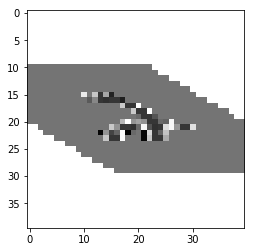

In [9]:
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28)

x, y = next(iter(valid_data_loader))
x_shear = shear_mnist_batch(x, return_size=40, shear_angle=-60)
# x_shear = torch.squeeze(x_shear)
img = x_shear[1, : , :, :]

imshow(torch_to_np(img), cmap='Greys',  interpolation='nearest')
torch.mean(img)

0
10
20
30
40
50


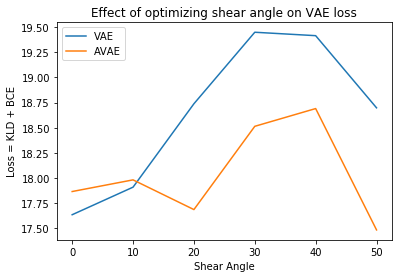

In [10]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=16, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'
data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=1, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)

results = pd.DataFrame()
results_opt = pd.DataFrame()
for rotation in range(0, 55, 10):
    print(rotation)
    log = get_shear_MNIST_perf(affine_model, data_loaders['val'], loss_fn, metric_fns, device, shear_angle=rotation, 
                                optimize=False, return_size=40, iterations=0, num_trials=0)
    log['shear'] = rotation
    results = results.append(log, ignore_index=True)
    
    log_opt = get_shear_MNIST_perf(affine_model, data_loaders['val'], loss_fn, metric_fns, device, shear_angle=rotation, 
                                optimize=True, return_size=40, iterations=0, num_trials=50)
    log_opt['shear'] = rotation
    results_opt = results_opt.append(log_opt, ignore_index=True)

results.to_csv('/media/rene/code/equivariance/results/affine_shear_nonopt_perf_50.csv')
results_opt.to_csv('/media/rene/code/equivariance/results/affine_shear_opt_perf_50.csv')

fig, ax = plt.subplots()
ax.plot(results['shear'], results['loss'], label="VAE")
ax.plot(results_opt['shear'], results_opt['loss'], label="AVAE")

ax.set(xlabel='Shear Angle', ylabel='Loss = KLD + BCE',
       title='Effect of optimizing shear angle on VAE loss')
ax.legend(loc='best')

plt.savefig('/media/rene/code/equivariance/imgs/shear_opt_perf_50.png', bbox='tight')
plt.show()

In [70]:
def display_vae_avae_shear(avae_model, files_dict_loc, num_samples=6, num_times=10, save_loc=None):
    
    data_loaders = make_generators_MNIST_CTRNFS(files_dict_loc, batch_size=128, num_workers=4, 
                                            return_size=28, rotation_range=None, normalize=False)
    
    x, y = next(iter(data_loaders['val']))
    rot_90 = shear_mnist_batch(x, return_size=40, shear_angle=
                               20)

    fig, ax = plt.subplots(2, num_samples, sharex=True, sharey=True, figsize=(12,8))
    row_names = ['VAE', 'AVAE']
    
    for i in range(num_samples):
        idx = random.randint(0, x.size()[0])
        img = x[idx, :, :, :].unsqueeze(0)
        img = img.to(device)
        rot_90_img = rot_90[idx, :, :, :].unsqueeze(0)
        rot_90_img = rot_90_img.to(device)

        rot_90_vae_output = avae_model.VAE(rot_90_img, deterministic=True)
        
        best_affine_params, loss = affine_model.optimize_affine_params(rot_90_img, only_shear=True, 
                                                                        num_times=num_times, iterations=0)
        rot_90_avae_output = avae_model(rot_90_img,  deterministic=True, affine_params=best_affine_params)
            
#         ax[0, i].imshow(torch_to_np(rot_90_img[:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        ax[0, i].imshow(torch_to_np(rot_90_vae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')
        ax[1, i].imshow(torch_to_np(rot_90_avae_output[0][:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')

        #TMP
#         ax[2, i].imshow(torch_to_np(ROTATION[:, :, 4:36, 4:36]), cmap='Greys',  interpolation='nearest')

        ax[0, 0].set_ylabel(row_names[0])
        ax[1, 0].set_ylabel(row_names[1])
#         ax[2, 0].set_ylabel(row_names[2])

#         ax[0, i].axis('off')
#         ax[1, i].axis('off')
#         ax[2, i].axis('off')
#     plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    
    if save_loc:
        plt.savefig(save_loc, bbox_inches='tight')
    
    plt.show()

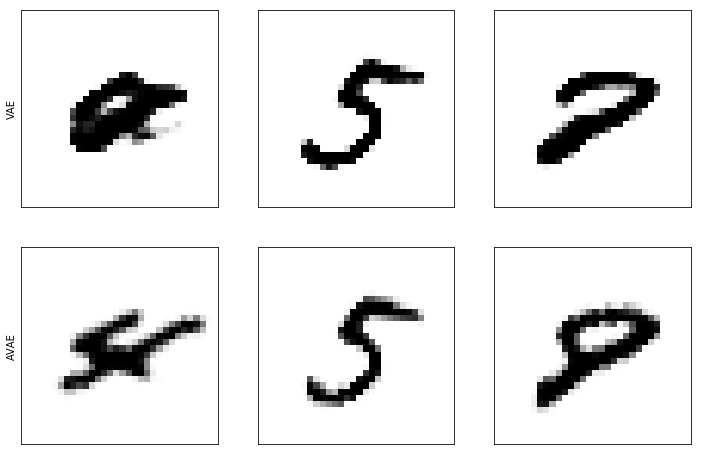

In [73]:
config_loc = '/media/rene/data/equivariance/mnist/vae_mnist_L16/0129_230250'
VAE, data_loader, valid_data_loader, loss_fn, metric_fns, config = get_model_loaders_config(config_loc, old_gpu='cuda:1', new_gpu='cuda:0')
VAE = VAE.to(device)

AffineVAE = getattr(module_arch, 'AffineVAE')
affine_model = AffineVAE(pre_trained_VAE=VAE, img_size=28, input_dim=1, output_dim=1, latent_size=8, use_STN=False)
affine_model = affine_model.to(device)

files_dict_loc = '/media/rene/data/MNIST/files_dict.pkl'

display_vae_avae_shear(affine_model, files_dict_loc, num_samples=3, num_times=100,
                       save_loc='/media/rene/code/equivariance/imgs/vae_avae_shear_ex.png')

In [60]:
x = torch.zeros(1, 6)
x = x.view(-1, 2, 3)
x[:, 0, 0] = 1
x[:, 1, 1] = 2

x[:, 0, 2] = 3
x[:, 1, 2] = 3

print(x)
A_inv =  torch.inverse(x[:, :, :2].squeeze())
b = x[:, :, 2].squeeze()
print(A_inv.size())
print(b.size())
x[:, :2, :2] = A_inv
x[:, :, 2] = -1*torch.mv(A_inv,b)
print(x)

x = torch.zeros(1)
x[0] = 360
torch.sin(x)

tensor([[[1., 0., 3.],
         [0., 2., 3.]]])
torch.Size([2, 2])
torch.Size([2])
tensor([[[ 1.0000, -0.0000, -3.0000],
         [ 0.0000,  0.5000, -1.5000]]])


tensor([0.9589])

In [14]:
tensor1 = torch.randn(16, 3, 4)
tensor2 = torch.randn(16, 4).unsqueeze(2)
torch.matmul(tensor1, tensor2).size()

torch.Size([16, 3, 1])